## New York Taxi fare Prediction

- Random Forest technique to predict the taxi fare
- Train data is huge so we will be taking only sample of data (100k records) for building the model
- Result will improve if increase the train size and do some Hyperparameter tuning with cross validation. Due to memory issue in Kaggle environment, chose to go with only 100k records.

## Steps Taken to build the model
- Load the data / Cleanup the data
- Feature Engineering
- Exploratory Data Anaysis
- Univariate and Bivariate Anaysis
- Distribution of data
- Random Forest for Predicting the taxi fare


## Result
- Random Forest: 78.4 % accuracy


## Final Result: Random forest accuracy is 78.41


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeRegressor

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import mean_squared_error

from sklearn.ensemble import StackingRegressor

In [2]:
## Load 100k rows only
data = pd.read_csv("/new-york-city-taxi-fare-prediction/train.csv", nrows=100_000, parse_dates=['pickup_datetime']) 


In [3]:
print(data.shape)
print(data.info())

(100000, 8)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 8 columns):
 #   Column             Non-Null Count   Dtype              
---  ------             --------------   -----              
 0   key                100000 non-null  object             
 1   fare_amount        100000 non-null  float64            
 2   pickup_datetime    100000 non-null  datetime64[ns, UTC]
 3   pickup_longitude   100000 non-null  float64            
 4   pickup_latitude    100000 non-null  float64            
 5   dropoff_longitude  100000 non-null  float64            
 6   dropoff_latitude   100000 non-null  float64            
 7   passenger_count    100000 non-null  int64              
dtypes: datetime64[ns, UTC](1), float64(5), int64(1), object(1)
memory usage: 6.1+ MB
None


In [4]:
data.head()

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21+00:00,-73.844311,40.721319,-73.841610,40.712278,1
1,2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:16+00:00,-74.016048,40.711303,-73.979268,40.782004,1
2,2011-08-18 00:35:00.00000049,5.7,2011-08-18 00:35:00+00:00,-73.982738,40.761270,-73.991242,40.750562,2
3,2012-04-21 04:30:42.0000001,7.7,2012-04-21 04:30:42+00:00,-73.987130,40.733143,-73.991567,40.758092,1
4,2010-03-09 07:51:00.000000135,5.3,2010-03-09 07:51:00+00:00,-73.968095,40.768008,-73.956655,40.783762,1


In [5]:
data.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000
mean,11.354652,-72.494682,39.914481,-72.490967,39.919053,1.673820
std,9.716777,10.693934,6.225686,10.471386,6.213427,1.300171
min,-44.900000,-736.550000,-74.007670,-84.654241,-74.006377,0.000000
25%,6.000000,-73.992041,40.734996,-73.991215,40.734182,1.000000
50%,8.500000,-73.981789,40.752765,-73.980000,40.753243,1.000000
75%,12.500000,-73.966982,40.767258,-73.963433,40.768166,2.000000
max,200.000000,40.787575,401.083332,40.851027,404.616667,6.000000


## Fare Amount Distribution

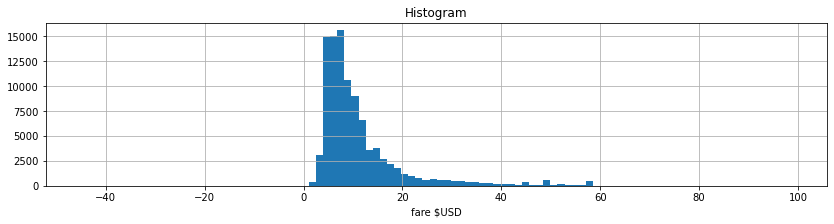

In [6]:
data[data.fare_amount<100].fare_amount.hist(bins=100, figsize=(14,3))
plt.xlabel('fare $USD')
plt.title('Histogram')
#majority of fareamount lie between -> 0 to 20 USD

### Calculate the distance between two GPS location
- actual lat long are not useful for modeling
- we will calculate the distance between two points

In [7]:
#The Haversine formula is used to calculate the distance
from math import sin, cos, sqrt, atan2, radians

def calculateDistance(lt1, ln1, lt2, ln2):

    # approximate radius of earth in km
    R = 6373.0

    lat1 = radians(lt1)
    lon1 = radians(ln1)
    lat2 = radians(lt2)
    lon2 = radians(ln2)

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))

    distance = R * c * 1000
    
    return distance

## Feature Engineering
- pickup_datetime will not help much in feature selection
- We can extract weekday and pickup_time from the pickup_datetime which will be very good feature for prediction
- Weekday will tell which day has peak day in the month
- Pickup Time will tell which is a peak hour in a day

## Data Cleanup
- Remove the rows which have fare amount as negative which doesn't make sense
- Remove the rows which have distance as <=0
- Also we will remove all the rows which have nan values

In [8]:
#remove -ve fare amounts
#seperate weekday,pickup_hour,pickup_time from pickup_datetime
#calculate distance from pickup_latitude to dropoff_latitude && pickup_longitude to dropoff_longitude
def featureCleanup(dfOrig, train = True):
    if(train):
        df = dfOrig[dfOrig['fare_amount'] >= 0]
    else:
        df = dfOrig.copy()
        
    df['weekday'] = df['pickup_datetime'].dt.day_name()
    df['pickup_hour'] = df['pickup_datetime'].dt.hour
    df['pickup_time'] = df['pickup_datetime'].dt.hour + df['pickup_datetime'].dt.minute/60
    
    df['distance'] = df.apply(lambda x: 
                              calculateDistance(x['pickup_latitude'], 
                                                x['pickup_longitude'],
                                                x['dropoff_latitude'],
                                                x['dropoff_longitude']), 
                              axis=1)
    
    df.drop(columns = ['pickup_latitude','pickup_longitude','dropoff_latitude','dropoff_longitude','pickup_datetime','key'], 
          inplace = True)
    
    if(train):
        df.dropna(
            axis=0,
            how='any',
            thresh=None,
            subset=None,
            inplace=True
        )

        df = df[df['distance'] > 0]
    
    return df

In [9]:
trainData = featureCleanup(data)

In [10]:
trainData.head()

,fare_amount,passenger_count,weekday,pickup_hour,pickup_time,distance
0,4.5,1,Monday,17,17.433333,1031.087515
1,16.9,1,Tuesday,16,16.866667,8452.786283
2,5.7,2,Thursday,0,0.583333,1389.961429
3,7.7,1,Saturday,4,4.500000,2800.148994
4,5.3,1,Tuesday,7,7.850000,1999.784368


# Exploratory Data Analysis

## Bivariate Analysis
- Generally taxi fares are expensive on Sundays 
- Generally people are travelling on Sundays or Wednesday (wednesday has max distance because of an outlier)
- Taxi fare is maximum during 2AM - 4AM. Midnight Charges ?
- Outlier causing issue with distance vs fare distribution

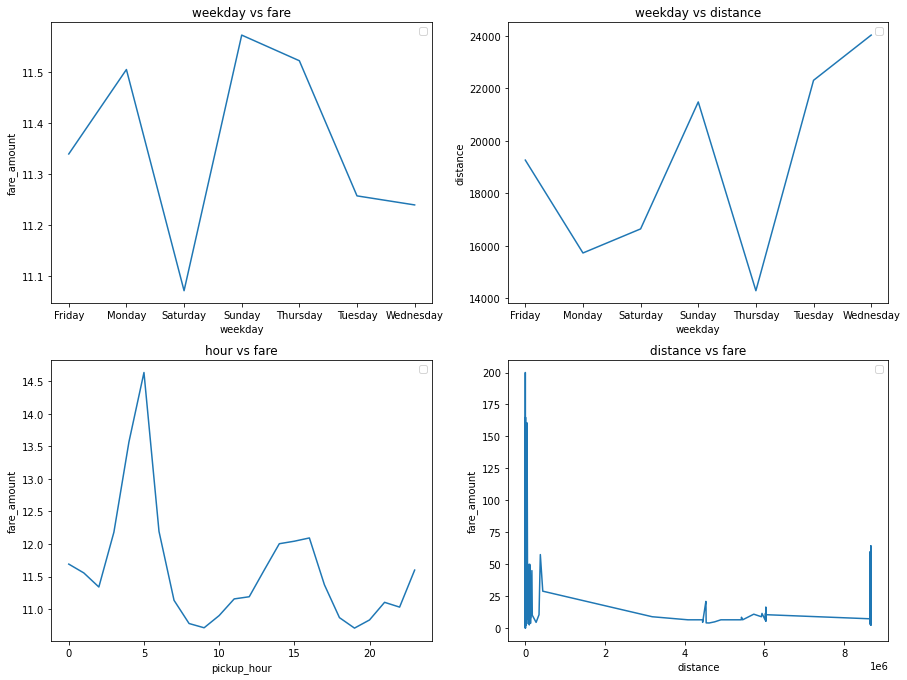

In [12]:
plt.figure(figsize  = (15,30))
plotChart(trainData.groupby(by="weekday").mean().reset_index(), 'weekday', 'fare_amount', 'weekday vs fare', 1)
plotChart(trainData.groupby(by="weekday").mean().reset_index(), 'weekday', 'distance', 'weekday vs distance', 2)
plotChart(trainData.groupby(by="pickup_hour").mean().reset_index(), 'pickup_hour', 'fare_amount', 'hour vs fare', 3)
plotChart(trainData.groupby(by="distance").mean().reset_index(), 'distance', 'fare_amount', 'distance vs fare', 4)

## Univariate Analysis
- Single passenger Taxi hire has maximum trend, hiring taxi from office to home ?
- Thurday, Friday and Saturday has maximum taxi hiring count
- Moderate hour is from 9:00 AM to 5:00 PM
- Peak hour is from 6:00PM to 9:00PM, leaving from office to home ?

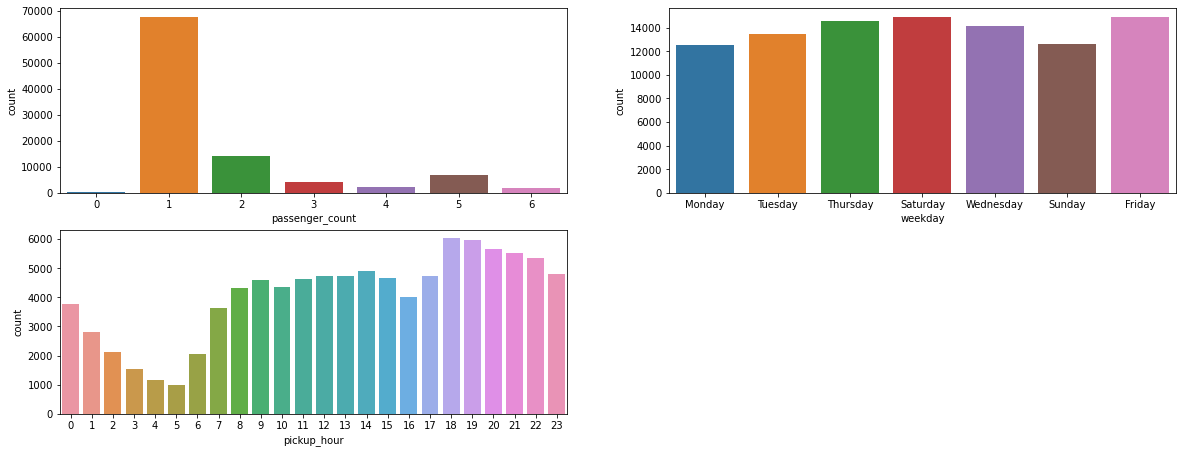

In [13]:
plt.figure(figsize  = (20,40))
for i in enumerate(trainData.columns.drop(['fare_amount', 'distance', 'pickup_time'])):
    plt.subplot(10, 2, i[0]+1)
    sns.countplot(trainData[i[1]])


## Outliers Detection
- There are outliers in the dataset but it will not impact on ML models based on decision tree.
- Outlier detection and treatment are not required here.

### Convert Weekday names with numeric numbers
- ML models always look for numbers not String values so converting weeknames to weeknumber.

In [14]:
trainData.drop(columns=['pickup_hour'], inplace=True)
trainData['weekday'] = trainData['weekday'].map({"Monday": 1, "Tuesday": 2, "Wednesday": 3, "Thursday": 4, "Friday": 5, "Saturday": 6, "Sunday": 7})

In [15]:
y_train = trainData.pop('fare_amount')
X_train = trainData

In [16]:
X_train.head()

,passenger_count,weekday,pickup_time,distance
0,1,1,17.433333,1031.087515
1,1,2,16.866667,8452.786283
2,2,4,0.583333,1389.961429
3,1,6,4.500000,2800.148994
4,1,2,7.850000,1999.784368


# Random Forest

## Hyperparameter Tuning for Random Forest
- Number of estimator used 50
- max_depth used 6 to 8 to identify the best depth of the trees
- max_feature used from 2 to 4 to identify best number of features
- We can iterate this based on the results and tune the hyperparameter futher to get the optimal values

In [17]:
#parameter tuning
rfEstimator = RandomForestRegressor(random_state=42)
para_grids = {
            "n_estimators" : [50],
            "max_depth": [6,7,8],
            'max_features': [2,3,4]
        }

### Random forest will create 45 different trees for training the model and will use best tree for prediction

In [18]:
grid_rf = GridSearchCV(rfEstimator, para_grids, verbose=1, n_jobs=-1, cv=5)
grid_rf.fit(X_train, y_train)
grid_rf.best_estimator_

Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:  1.3min finished


RandomForestRegressor(max_depth=6, max_features=4, n_estimators=50,
                      random_state=42)

In [19]:
y_train_pred_rf = grid_rf.predict(X_train)
print("Random Forest Accuracy:", round(r2_score(y_train, y_train_pred_rf)*100, 2), "%")

Random Forest Accuracy: 78.41 %


## Random forest accuracy is 78.41
